# Desafio P&D (Machine Learning) Intelivix

## O desafio conciste em fazer a análise de sentimentos de reviews de filmes com objetivo de prever se os comentários são: negativos, pouco negativo, neutro, pouco positivo, positivo.



In [117]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
%matplotlib inline 

## Analisando os dados: carregando o arquivo train.tsv e verificando seus dados.

In [125]:
#lendo o arquivo train.tsv
train_review = pd.read_csv('train.tsv',sep ='\t') 

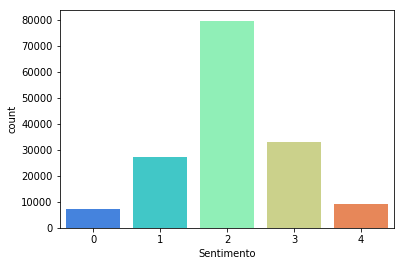

In [126]:
#Criando um countplot para verificar se o banco esta balanceado.
sns.countplot(x='Sentimento', data = train_review, palette = 'rainbow')

###### Como podemos ver o banco não esta balanceado, provavelmente pela grande quantidade de ruídos, ou seja: comentários repetidos, comentarios nulos ou comentarios apenas com uma palavra. 

In [127]:
train_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
Id            156060 non-null int64
IdSentenca    156060 non-null int64
Texto         156060 non-null object
Sentimento    156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


#### Dropando a coluna Id para reduzir o número de informações desnecessárias.

In [128]:
train_review = train_review.drop(['Id'],axis=1)

In [129]:
train_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 3 columns):
IdSentenca    156060 non-null int64
Texto         156060 non-null object
Sentimento    156060 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [124]:
train_review

,Id,IdSentenca,Texto,Sentimento
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


#### O primeiro passo consiste em escrever uma função que ira partir a string em palavras individuais e retornar uma lista. Também eliminaremos as stopwords, caractéres especiais, pontuação e transformaremos todas as palavras em lowercase.

In [131]:
def textprocess(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc =''.join(nopunc)
    nopunc = re.sub('[^a-zA-Z0-9]',' ',nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]         

In [132]:
train_review.drop_duplicates(subset ='IdSentenca', inplace = True)

In [133]:
train_review.set_index('IdSentenca', inplace =True)

In [134]:
train_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8529 entries, 1 to 8544
Data columns (total 2 columns):
Texto         8529 non-null object
Sentimento    8529 non-null int64
dtypes: int64(1), object(1)
memory usage: 199.9+ KB


#### Podemos observar a incocistência do banco de dados através do método info(). Antes de fazer um oversample para balancear o banco, irei analiza-lo inicialmente desta forma. 

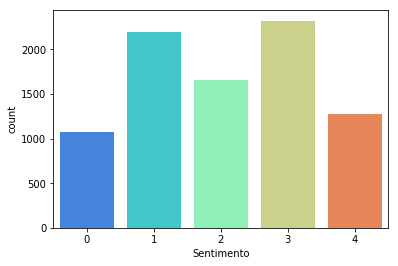

In [82]:
sns.countplot(x='Sentimento', data = train_review, palette = 'rainbow')

In [135]:
train_review

,Texto,Sentimento
IdSentenca,,
1,A series of escapades demonstrating the adage ...,1
2,"This quiet , introspective and entertaining in...",4
3,"Even fans of Ismail Merchant 's work , I suspe...",1
4,A positively thrilling combination of ethnogra...,3
5,Aggressive self-glorification and a manipulati...,1
6,A comedy-drama of nearly epic proportions root...,4
7,"Narratively , Trouble Every Day is a plodding ...",1
8,"The Importance of Being Earnest , so thick wit...",3
9,But it does n't leave you with much .,1


#### Aqui verificamos se a função textprocess esta funcionando do jeito esperado. Pelo output o objetivo foi alcançado.

In [10]:
train_review['Texto'].head(5).apply(textprocess)

IdSentenca
1    [series, escapades, demonstrating, adage, good...
2    [quiet, introspective, entertaining, independe...
3    [Even, fans, Ismail, Merchant, work, suspect, ...
4    [positively, thrilling, combination, ethnograp...
5    [Aggressive, selfglorification, manipulative, ...
Name: Texto, dtype: object

# Multinomial Naive Bayes
### O primeiro método utilizado por mim foi o Naive Bayes. Naive Bayes é um método classico de classificação de texto que considera a total independência entre as features, dai o nome naive. Foi criado um pipeline para dinamizar vetorização das palavras e calular o peso das strings no texto atráves do TfidTransformer, ou seja, o qual importante é a palavra no documento em questão.

In [111]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=textprocess)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [112]:
X= train_review['Texto']
Y = train_review['Sentimento']
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3,random_state=101)

In [113]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function textprocess at 0x000002822FF04730>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [114]:
predictions = pipeline.predict(X_test)

In [115]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       1.00      0.00      0.01       330
          1       0.38      0.59      0.46       666
          2       0.37      0.04      0.07       472
          3       0.37      0.78      0.50       697
          4       0.77      0.04      0.08       394

avg / total       0.52      0.38      0.28      2559



## Linear Support Vector Machine
### O segundo método utilizado foi o SVM linear. Este método é mais lento do que o naive bayes, porém a acurácia dele é supostamente maior para uma grande quantidade de dados.

In [136]:
pipeline_1 = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfidf', TfidfTransformer()),  
    ('classifier',SGDClassifier(loss='hinge', penalty='l2',
                               alpha=1e-3, random_state=42,
                                max_iter=5, tol=None, verbose=4)),  
])

In [137]:
pipeline_1.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [138]:
predictions2 = pipeline_1.predict(X_test)

In [139]:
print(classification_report(y_test,predictions2))

             precision    recall  f1-score   support

          0       0.38      0.25      0.30       330
          1       0.40      0.43      0.41       666
          2       0.24      0.22      0.23       472
          3       0.41      0.51      0.45       697
          4       0.45      0.38      0.41       394

avg / total       0.38      0.38      0.37      2559



# Logistic Regression
### O terceiro modelo utilizado foi o a regressão logistica.

In [102]:
pipeline_2 = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfidf', TfidfTransformer()),  
    ('classifier', LogisticRegression()),  
])

In [103]:
pipeline_2.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [104]:
predictions3 = pipeline_2.predict(X_test)

In [105]:
print(classification_report(y_test,predictions3))

             precision    recall  f1-score   support

          0       0.52      0.08      0.15       330
          1       0.40      0.54      0.46       666
          2       0.25      0.14      0.18       472
          3       0.39      0.66      0.49       697
          4       0.57      0.23      0.33       394

avg / total       0.41      0.39      0.35      2559



# Conclusão:
###  Para a aplicação em questão concluimos que o naive bayes teve uma melhor acurácia para a classificação de sentimentos, não foi realizado . 